In [52]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y + 2

#  セッションを開いて、変数を初期化してfを評価する
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
sess.close()

# with ブロックを使用
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

# initで全ての変数を初期化する
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    result = f.eval()

    # InteracticeSession を作ると自動的にデフォルトセッションになる
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

Instructions for updating:
Colocations handled automatically by placer.
42


In [19]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [21]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


In [23]:
w = tf.constant(3)
x =w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())
    
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y.eval())
    print(z.eval())
 

10
15
10
15


In [3]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n =housing.data.shape

housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name='y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()


In [55]:
from sklearn.preprocessing import StandardScaler
n_epochs = 1000
learning_rate = 0.01

sc = StandardScaler()
scaled_housing_data_plus_bias = sc.fit_transform(housing_data_plus_bias)
print(housing.target)

X = tf.constant(scaled_housing_data_plus_bias, dtype =tf.float32, name ='X')
y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name='y' )

theta = tf.Variable(tf.random_uniform([n+1,1],-1.0, 1.0), name = 'theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error),name='mse')
# 勾配の計算
#gradients = 2/m*tf.matmul(tf.transpose(X), error)
#gradients = tf.gradients(mse,[theta])[0]

# 変数の値を更新　
#training_op = tf.assign(theta, theta - learning_rate * gradients)

# Tensor Flow に実装されているオプティマイザを使う場合
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) #SGD
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

training_op = optimizer.minimize(mse)


init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch %100 == 0:
            print('Epoch',epoch, 'MSE = ',mse.eval())
        sess.run(training_op)

        best_theta = theta.eval()

[4.526 3.585 3.521 ... 0.923 0.847 0.894]
Epoch 0 MSE =  7.571035
Epoch 100 MSE =  4.809864
Epoch 200 MSE =  4.803888
Epoch 300 MSE =  4.803334
Epoch 400 MSE =  4.8032646
Epoch 500 MSE =  4.803255
Epoch 600 MSE =  4.8032546
Epoch 700 MSE =  4.8032537
Epoch 800 MSE =  4.8032537
Epoch 900 MSE =  4.8032546


In [56]:
A = tf.placeholder(tf.float32, shape=(None,3))
B = A + 3
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A:[[1,2,3]]})
    B_val_2 = B.eval(feed_dict={A:[[4,5,6],[7,8,9]]})

print(B_val_1)
print(B_val_2)

[[4. 5. 6.]]
[[ 7.  8.  9.]
 [10. 11. 12.]]


In [16]:
def fetch_batch(epoch, batch_index, batch_size):

    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch


In [81]:
batch_size = 100
n_batches = int(np.ceil(m/batch_size))

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None,n+1),name='X')
y = tf.placeholder(tf.float32, shape=(None,1), name='y')

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
saver2 = tf.train.Saver({'weight':theta})

with tf.Session() as sess:
    sess.run(init)

    for epoch in tqdm(range(n_epochs)):
        if epoch % 100 ==0:
            save_path = saver.save(sess,'tmp/my_model.ckpt')
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()
    save_path = saver.save(sess,'tmp/my_model_final.index')
    

100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


In [80]:
with tf.Session() as sess:
    saver.restore(sess, 'tmp/my_model_final.ckpt')
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from tmp/my_model_final.ckpt


In [78]:
saver = tf.train.import_meta_graph('tmp/my_model_final.ckpt.meta')
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess,'tmp/my_model_final.ckpt')

In [18]:
from datetime import datetime
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_housing_data_plus_bias = sc.fit_transform(housing_data_plus_bias)

n_epochs = 10
learning_rate = 0.01
batch_size = 100
n_batchs = int(np.ceil(m/batch_size))


X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

# ログの書き込み
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(batch_size):
            X_batch, y_batch = fetch_batch(epoch, batch_index,batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X:X_batch,y:y_batch})
                step = epoch * n_batchs + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    best_theta = theta.eval()


In [21]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope('loss') as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name='mse')
    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE',mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())



with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[-0.1673944 ]
 [ 0.83614284]
 [ 0.13476901]
 [-0.33433765]
 [ 0.35590392]
 [-0.0069896 ]
 [-0.04888977]
 [-0.80721265]
 [-0.78512955]]


In [37]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope('relu'):
        w_shape = (int(X.get_shape()[1]),1)
        w = tf.Variable(tf.random_normal(w_shape),name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(X, w), b, name='z')
        return tf.maximum(z, threshold, name='max')

n_features = 3
threshold = tf.Variable(0.0, name='threshold')
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X,threshold) for i in range(5)]
output = tf.add_n(relus, name='output')

file_writer = tf.summary.FileWriter('logs/max', tf.get_default_graph())
file_writer.close()

In [38]:
reset_graph()

def relu(X):
    with tf.name_scope('relu'):
        if not hasattr(relu, 'threshold'):
            relu.threshold = tf.Variable(0.0, name='threshold')
        w_shape = (int(X.get_shape()[1]),1)
        w = tf.Variable(tf.random_normal(w_shape),name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(X, w), b, name='z')
        return tf.maximum(z, relu.threshold, name='max')

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name='output')

file_writer = tf.summary.FileWriter('logs/max2', tf.get_default_graph())
file_writer.close()

In [40]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
    # 既存変数を再利用
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    # 変数を作成
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [42]:
reset_graph()

def relu(X):
# 既存変数を再利用
    threshold = tf.get_variable("threshold",shape=(),initializer=tf.constant_initializer(0.0))
    w_shape = int(X.get_shape()[1]), 1                          # not shown
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope('relu', reuse=(relu_index>=1 or None)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name='ouptut')
file_writer = tf.summary.FileWriter('logs/max3', tf.get_default_graph())
file_writer.close()

In [48]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


## ロジスティック回帰

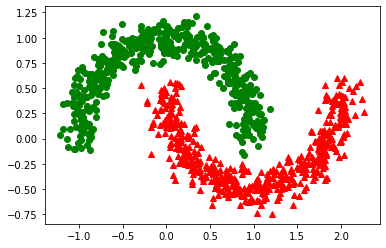

In [55]:
from sklearn.datasets import make_moons
m = 1000
X, y = make_moons(m, noise=0.1, random_state=42)
plt.plot(X[y==0,0], X[y==0,1], 'go')
plt.plot(X[y==1,0], X[y==1,1], 'r^')
plt.show()

In [60]:
from sklearn.model_selection import train_test_split
X_bias = np.c_[np.ones((m,1)), X]
y_vector = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_bias, y_vector, test_size=0.2,random_state=0)

In [61]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [66]:
reset_graph()
n_inputs = 2
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None,1), name='y')
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name='theta')
logits = tf.matmul(X, theta, name='logits')
# sigmoid
y_proba = 1/(1 + tf.exp(-logits))
# y_proba = tf.sigmoid(logits)

epsilon = 1e-7
# logloss
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

# loss = tf.losses.log_loss(y, y_pred)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [68]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        loss_val = loss.eval({X:X_test, y:y_test})
        if epoch % 100 ==0:
            print('Epoch:',epoch, '\tloss:', loss_val)
    y_proba_val = y_proba.eval(feed_dict={X:X_test, y:y_test})

Epoch: 0 	loss: 0.7757045
Epoch: 100 	loss: 0.3354473
Epoch: 200 	loss: 0.30104637
Epoch: 300 	loss: 0.28803813
Epoch: 400 	loss: 0.28240624
Epoch: 500 	loss: 0.2799915
Epoch: 600 	loss: 0.2774447
Epoch: 700 	loss: 0.27658215
Epoch: 800 	loss: 0.2765277
Epoch: 900 	loss: 0.27613446


In [72]:
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
print(precision_score(y_test, y_pred))
print(recall_score(y_test,y_pred))

0.8505747126436781
0.8809523809523809


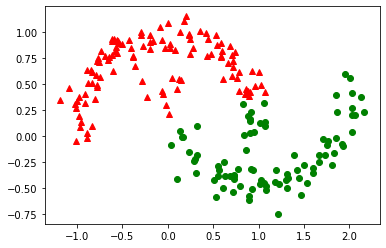

In [76]:
y_pred_idx = y_pred.reshape(-1)
plt.plot(X_test[y_pred_idx,1], X_test[y_pred_idx,2],'go')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^')
plt.show()

In [82]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [77]:
reset_graph()
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [78]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [79]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Instructions for updating:
Use tf.cast instead.


In [83]:
import os 
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.6527206
Epoch: 500 	Loss: 0.16210788
Epoch: 1000 	Loss: 0.12401244
Epoch: 1500 	Loss: 0.1037854
Epoch: 2000 	Loss: 0.09075118
Epoch: 2500 	Loss: 0.08171265
Epoch: 3000 	Loss: 0.07496356
Epoch: 3500 	Loss: 0.06966597
Epoch: 4000 	Loss: 0.0653838
Epoch: 4500 	Loss: 0.06176119
Epoch: 5000 	Loss: 0.058748923
Epoch: 5500 	Loss: 0.056187306
Epoch: 6000 	Loss: 0.05393056
Epoch: 6500 	Loss: 0.052014966
Epoch: 7000 	Loss: 0.050218806
Epoch: 7500 	Loss: 0.048668157
Epoch: 8000 	Loss: 0.047300357
Epoch: 8500 	Loss: 0.046023063
Epoch: 9000 	Loss: 0.04482406
Epoch: 9500 	Loss: 0.043756854
Epoch: 10000 	Loss: 0.042787503
